In [39]:
#Import 
import numpy as np
from pathlib import Path
import pandas as pd
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures # For Polynomial basis functions
from sklearn.pipeline import make_pipeline # to link different objects
from matplotlib import cm # to change colors of surface plots
import matplotlib.pyplot as plt # import plotting tools to create figures
from sklearn.gaussian_process import GaussianProcessRegressor,GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


In [40]:
df_in_7d = pd.read_csv('data/supercompressible_7d_input.csv')
df_out_7d = pd.read_csv('data/supercompressible_7d_output.csv')

df_in_3d = pd.read_csv('data/supercompressible_3d_input.csv')
df_out_3d = pd.read_csv('data/supercompressible_3d_output.csv')

In [41]:
# define a function to do the preprocessing
# Input: input_raw_data, output_raw_data, problem_class
# input_raw_data: pandas dataframe for input
# output_raw_data: pandas dataframe for output
# problem_class: (booler) to describe this preprocess is for classification problem or not
#                this will lead to different scaler for Y data.
#
# Output: X_train_scale, X_test_scale, X_scale, Y_train_scale, Y_test_scale, Y_scale, scaler_x, scaler_y
# scaler_x: (scaler) used to do inverse_transfer after prediction
# scaler_y: (scaler) used to do inverse_transfer after prediction

def preprocess_3d(input_raw_data,output_raw_data,problem_class, testset_ratio=0.25):
    if problem_class == False:
        raw_data = pd.concat([input_raw_data, output_raw_data], axis=1)

        # look at the # of missing points in the first ten columns
        raw_data_drop_nan = raw_data.dropna()

        X_3d = raw_data_drop_nan.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
        Y_3d = raw_data_drop_nan.loc[:, ['sigma_crit','energy'] ].values
        
        #testset_ratio = 0.25
        SEED = 123
        X_train, X_test, Y_train, Y_test = train_test_split(X_3d,
                                            Y_3d, test_size=testset_ratio,
                                            random_state=SEED)

        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_scale=scaler_x.transform(X_train)
        X_test_scale=scaler_x.transform(X_test)
        X_scale=scaler_x.transform(X_3d)
        
        scaler_y = StandardScaler()
        scaler_y.fit(Y_train)
        Y_train_scale = scaler_y.transform(Y_train)
        Y_test_scale = scaler_y.transform(Y_test)
        Y_scale = scaler_y.transform(Y_3d)
    else:
        X_3d = input_raw_data.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
        Y_3d = output_raw_data.loc[:, 'coilable'].values
        
        #testset_ratio = 0.25
        SEED = 123
        X_train, X_test, Y_train, Y_test = train_test_split(X_3d,
                                            Y_3d, test_size=testset_ratio,
                                            random_state=SEED)

        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_scale=scaler_x.transform(X_train)
        X_test_scale=scaler_x.transform(X_test)
        X_scale=scaler_x.transform(X_3d)

        scaler_y = FunctionTransformer() # FunctionTransformer without input will give a Identity scaler
        Y_train_scale = scaler_y.transform(Y_train)
        Y_test_scale = scaler_y.transform(Y_test)
        Y_scale = scaler_y.transform(Y_3d)

    return X_train_scale, X_test_scale, X_scale, Y_train_scale, Y_test_scale, Y_scale, scaler_x, scaler_y

In [42]:
# Define function to do the model training and predicting
# Input: X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,model
# X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,: scaled data set for classification
# model: any model for predict classification problem
#
# Output: ac_score,pr_score,re_score,f_one_score,con_matrix
# ac_score: accuracy_score with test sample
# pr_score: precision_score with test sample
# re_score: recall_score with test sample
# f_one_score: f1_score with test sample
# con_matrix: confusion_matrix with test sample 

def classification_model_train_and_predict(X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,model):
    model.fit(X_train,Y_train)
    Y_predict_for_test = model.predict(X_test)
    ac_score = accuracy_score(Y_test,Y_predict_for_test)
    pr_score = precision_score(Y_test,Y_predict_for_test,average='micro')
    re_score = recall_score(Y_test,Y_predict_for_test,average='micro')
    f_one_score = f1_score(Y_test,Y_predict_for_test,average='micro')
    con_matrix = confusion_matrix(Y_test,Y_predict_for_test)

    #classification_model_plot(X_data,Y_data,scaler_x, scaler_y,model,249,20)

    return ac_score,pr_score,re_score,f_one_score,con_matrix

In [43]:
def regression_model_train_and_predict(X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x,scaler_y,model):
    model.fit(X_train,Y_train)
    Y_predict_for_test = model.predict(X_test)
    r2 = r2_score(Y_test,Y_predict_for_test)
    mse = mean_squared_error(Y_test,Y_predict_for_test)

    #regression_model_plot(X_data,Y_data,scaler_x,scaler_y,model,5,10,True)
    # this function is not finished, and we can just check r2 score and mse for comparing our results

    return r2, mse

## Study the influence of the number of training points

In [46]:
testset_ratio_space = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
class_result_space = []
regression_result_space = []

SVM_model = svm.SVC(kernel='rbf', C=1.0, gamma=0.7)
kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5),nu=2.5)
gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=40)

for ratio in testset_ratio_space:
    X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class, scaler_x_class, scaler_y_class = preprocess_3d(df_in_3d,df_out_3d,True,testset_ratio=ratio)

    X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression, scaler_x_regression, scaler_y_regression = preprocess_3d(df_in_3d,df_out_3d,False,testset_ratio=ratio)

    ac_score,pr_score,re_score,f_one_score,con_matrix = classification_model_train_and_predict(X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class,scaler_x_class, scaler_y_class,SVM_model)

    r2, mse = regression_model_train_and_predict(X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression,scaler_x_regression, scaler_y_regression,gpr_model)
    class_result = []
    class_result.append(ac_score)
    class_result.append(pr_score)
    class_result.append(re_score)
    class_result.append(f_one_score)
    class_result.append(con_matrix)

    regression_result = []
    regression_result.append(r2)
    regression_result.append(mse)

    class_result_space.append(class_result)
    regression_result_space.append(regression_result)


Text(0, 0.5, 'accuracy score')

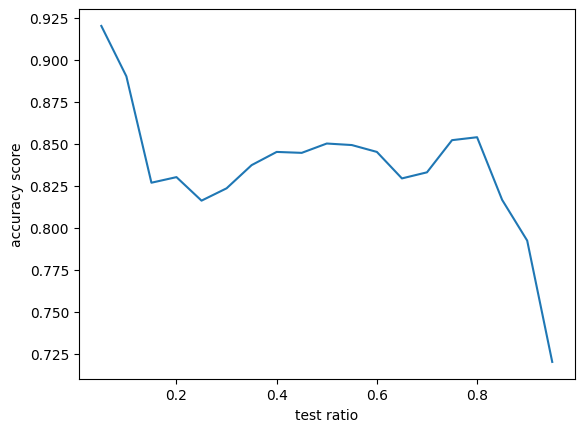

In [87]:
ac_score_sapce = []
for class_result in class_result_space:
    ac_score_sapce.append(class_result[0])

plt.plot(testset_ratio_space,ac_score_sapce)
plt.xlabel('test ratio')
plt.ylabel('accuracy score')

Text(0, 0.5, 'r2 score')

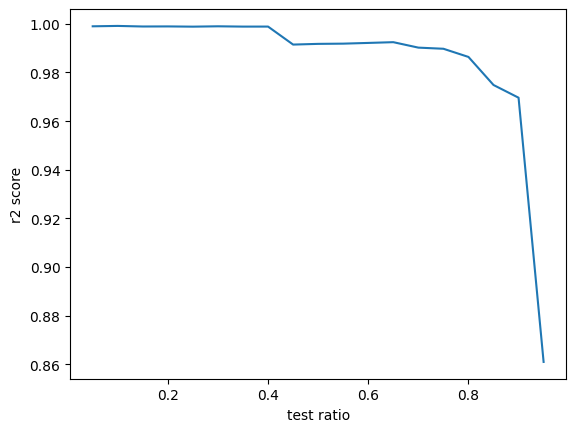

In [88]:
r2_score_sapce = []
for regression_result in regression_result_space:
    r2_score_sapce.append(regression_result[0])

plt.plot(testset_ratio_space,r2_score_sapce)
plt.xlabel('test ratio')
plt.ylabel('r2 score')

## Study the influence of hyper-parameters

In [71]:
X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class, scaler_x_class, scaler_y_class = preprocess_3d(df_in_3d,df_out_3d,True)
#X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression, scaler_x_regression, scaler_y_regression = preprocess_3d(df_in_3d,df_out_3d,False)

C_space = [1e-3,5e-3,1e-2,2e-2,3e-2,4e-2,5e-2,1e-1,5e-1,1.0,5.0,1e1,5e1,1e2,5e2,1e3,5e3,1e4]
C_result_sapce = []

for C_value in C_space:
    SVM_model = svm.SVC(kernel='rbf', C=C_value, gamma=0.7)
    ac_score,pr_score,re_score,f_one_score,con_matrix = classification_model_train_and_predict(X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class,scaler_x_class, scaler_y_class,SVM_model)
    C_result = []
    C_result.append(ac_score)
    C_result.append(pr_score)
    C_result.append(re_score)
    C_result.append(f_one_score)
    C_result.append(con_matrix)
    
    C_result_sapce.append(C_result)


Text(0, 0.5, 'accuracy score')

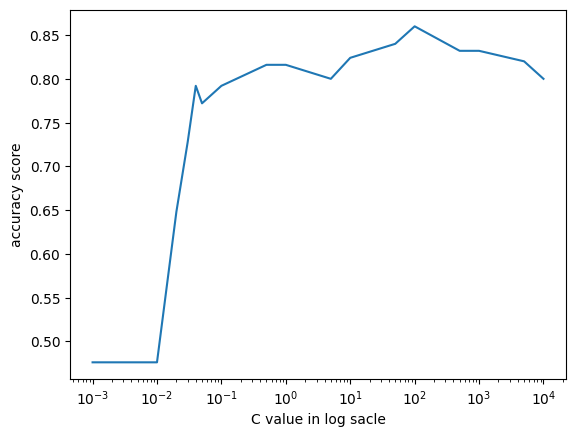

In [92]:
ac_score_sapce_C = []
for C_result in C_result_sapce:
    ac_score_sapce_C.append(C_result[0])

plt.semilogx(C_space,ac_score_sapce_C)
plt.xlabel('C value in log sacle')
plt.ylabel('accuracy score')

In [77]:
X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression, scaler_x_regression, scaler_y_regression = preprocess_3d(df_in_3d,df_out_3d,False)

nu_sapce = [0.5, 1.5, 2.5,3.5,5.5,10.5, np.inf]
nu_result_sapce = []

for nu_value in nu_sapce:
    kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5),nu=nu_value)
    gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=40)
    r2, mse = regression_model_train_and_predict(X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression,scaler_x_regression, scaler_y_regression,gpr_model)
    nu_result = []
    nu_result.append(r2)
    nu_result.append(mse)

    nu_result_sapce.append(nu_result)

/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


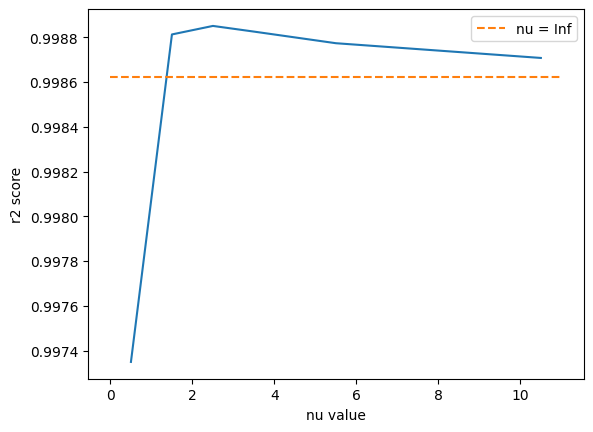

In [91]:
r2_score_sapce_nu = []
for nu_result in nu_result_sapce:
    r2_score_sapce_nu.append(nu_result[0])

plt.plot(nu_sapce,r2_score_sapce_nu)
plt.plot([0,11],[nu_result_sapce[6][0],nu_result_sapce[6][0]],'--',label='nu = Inf')
plt.xlabel('nu value')
plt.ylabel('r2 score')
plt.legend()